In [7]:
# Part 1
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from datetime import datetime
import duckdb

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ----------------------------- ---------- 7.3/9.8 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 35.8 MB/s  0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ----------

In [18]:
# Load NYC 311 sample data

csv_path = r"C:\Users\andre\Downloads\nyc_311_sample.csv"
parquet_path = r"C:\Users\andre\Downloads\nyc_311_sample.parquet"

duckdb.sql(f"""
  COPY (SELECT * FROM read_csv_auto('{csv_path}', header=True, all_varchar=1))
  TO '{parquet_path}' (FORMAT PARQUET);
""")

print("✅ Converted to Parquet:", parquet_path)



✅ Converted to Parquet: C:\Users\andre\Downloads\nyc_311_sample.parquet


In [19]:
df = pd.read_parquet(parquet_path)
print(df.head(10))

  Unique Key            Created Date Closed Date Agency  \
0   65929518  08/24/2025 01:36:23 AM        None   NYPD   
1   65935681  08/24/2025 01:36:20 AM        None   NYPD   
2   65928342  08/24/2025 01:36:13 AM        None   NYPD   
3   65930684  08/24/2025 01:36:08 AM        None   NYPD   
4   65927063  08/24/2025 01:36:03 AM        None   NYPD   
5   65927146  08/24/2025 01:36:01 AM        None   NYPD   
6   65930690  08/24/2025 01:35:44 AM        None   NYPD   
7   65928260  08/24/2025 01:35:44 AM        None   NYPD   
8   65929502  08/24/2025 01:35:35 AM        None   NYPD   
9   65930683  08/24/2025 01:35:03 AM        None   NYPD   

                       Agency Name           Complaint Type        Descriptor  \
0  New York City Police Department  Noise - Street/Sidewalk  Loud Music/Party   
1  New York City Police Department  Noise - Street/Sidewalk  Loud Music/Party   
2  New York City Police Department  Noise - Street/Sidewalk  Loud Music/Party   
3  New York City Police De

In [20]:
#check duplicates
num_dupes = df.duplicated().sum()
print(f"Number of duplicate rows: {num_dupes}")

Number of duplicate rows: 0


In [ ]:
#check missing values and clean them in part 2

In [21]:
# Part 2
# Basic Data Profiling: Analyze service request status distribution
status_counts = df['Status'].value_counts()
for status, count in status_counts.head().items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

  Closed: 6,676,339 (97.4%)
  In Progress: 115,913 (1.7%)
  Open: 37,569 (0.5%)
  Assigned: 16,033 (0.2%)
  Pending: 7,343 (0.1%)


In [22]:
# Missing Value Analysis:
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})
missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)
print("Top 10 columns with missing values:")
top_missing = missing_analysis[missing_analysis['Missing_Count'] > 0].head(10)
for _, row in top_missing.iterrows():
    print(f"  {row['Column']}: {row['Missing_Count']:,} ({row['Missing_Percentage']:.1f}%)")

Top 10 columns with missing values:
  Taxi Company Borough: 6,852,008 (99.9%)
  Road Ramp: 6,839,370 (99.8%)
  Bridge Highway Direction: 6,833,115 (99.7%)
  Due Date: 6,819,944 (99.5%)
  Bridge Highway Name: 6,813,091 (99.4%)
  Bridge Highway Segment: 6,813,081 (99.4%)
  Taxi Pick Up Location: 6,783,721 (98.9%)
  Vehicle Type: 6,574,746 (95.9%)
  Facility Type: 6,334,861 (92.4%)
  Landmark: 2,640,804 (38.5%)


In [23]:
# Drop those columns with high percentage of missing values
high_missing_cols = missing_analysis.loc[
    missing_analysis["Missing_Percentage"] > 90, "Column"
]

df = df.drop(columns=high_missing_cols)

In [28]:
# Complaint Type Analysis: Identify the most common service request
top_complaints = df['Complaint Type'].value_counts().head(15)
print("Top 15 Complaint Types:")
i = 1
for complaint, count in top_complaints.items():
    percentage = (count / len(df)) * 100
    print(str(i) + ". " + complaint + ": " + str(count) + " (" + str(round(percentage, 1)) + "%)")
    i = i + 1

Top 15 Complaint Types:
1. Illegal Parking: 1048081 (15.3%)
2. Noise - Residential: 752334 (11.0%)
3. HEAT/HOT WATER: 534388 (7.8%)
4. Blocked Driveway: 340087 (5.0%)
5. Noise - Street/Sidewalk: 328388 (4.8%)
6. UNSANITARY CONDITION: 213337 (3.1%)
7. Street Condition: 142168 (2.1%)
8. Water System: 140426 (2.0%)
9. Abandoned Vehicle: 139064 (2.0%)
10. Noise - Commercial: 136295 (2.0%)
11. PLUMBING: 119772 (1.7%)
12. Dirty Condition: 117275 (1.7%)
13. PAINT/PLASTER: 113785 (1.7%)
14. Noise: 109864 (1.6%)
15. Derelict Vehicles: 95435 (1.4%)


In [26]:
# Trend Analysis
df['Created Date'] = pd.to_datetime(df['Created Date'])
df['Year'] = df['Created Date'].dt.year
df['Month'] = df['Created Date'].dt.month
df['DayOfWeek'] = df['Created Date'].dt.day_name()
df['Hour'] = df['Created Date'].dt.hour
df['YearMonth'] = df['Created Date'].dt.to_period('M')

# Analyze yearly distribution
print("Requests by Year:")
yearly_counts = df['Year'].value_counts().sort_index()
for year, count in yearly_counts.items():
    print(f"  {year}: {count:,}")

# Analyze seasonal patterns (monthly distribution)
print("\nRequests by Month (average):")
monthly_avg = df.groupby('Month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, count in monthly_avg.items():
    month_name = month_names[month-1]
    print(f"  {month_name}: {count:,}")

# Analyze weekly patterns
print("\nRequests by Day of Week:")
dow_counts = df['DayOfWeek'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_order:
    if day in dow_counts:
        count = dow_counts[day]
        pct = (count / len(df)) * 100
        print(f"  {day}: {count:,} ({pct:.1f}%)")

Requests by Year:
  2023: 1,195,002
  2024: 3,458,320
  2025: 2,203,076

Requests by Month (average):
  Jan: 635,416
  Feb: 495,872
  Mar: 547,994
  Apr: 540,259
  May: 579,284
  Jun: 587,385
  Jul: 571,340
  Aug: 539,071
  Sep: 590,568
  Oct: 609,715
  Nov: 573,656
  Dec: 585,838

Requests by Day of Week:
  Monday: 1,035,669 (15.1%)
  Tuesday: 1,030,105 (15.0%)
  Wednesday: 1,001,514 (14.6%)
  Thursday: 990,356 (14.4%)
  Friday: 993,710 (14.5%)
  Saturday: 895,890 (13.1%)
  Sunday: 909,154 (13.3%)


In [27]:
# Requests distribution and per-capita analysis
print(" Requests by Borough:")
borough_stats = df['Borough'].value_counts()
for borough, count in borough_stats.items():
    if pd.notna(borough):
        percentage = (count / len(df)) * 100
        print(f"  {borough}: {count:,} ({percentage:.1f}%)")

# Most common complaint type per borough
print(f"\nTop Complaint by Borough:")
for borough in borough_stats.index[:5]:
    if pd.notna(borough):
        borough_data = df[df['Borough'] == borough]
        top_complaint = borough_data['Complaint Type'].value_counts().head(1)
        if not top_complaint.empty:
            complaint = top_complaint.index[0]
            count = top_complaint.iloc[0]
            pct = (count / len(borough_data)) * 100
            print(f"  {borough}: {complaint} ({count:,}, {pct:.1f}%)")

# Per capita analysis using 2020 Census data
print(f"\nRequests Per Capita by Borough (Estimated):")
borough_population = {
    'BROOKLYN': 2736074,
    'QUEENS': 2405464,
    'MANHATTAN': 1694251,
    'BRONX': 1472654,
    'STATEN ISLAND': 495747
}
print("Borough population estimates used (2020 Census):")
for borough in borough_stats.index[:5]:
    if pd.notna(borough) and borough in borough_population:
        requests = borough_stats[borough]
        population = borough_population[borough]
        per_capita = (requests / population) * 1000  # per 1,000 residents
        print(f"  {borough}: {per_capita:.2f} requests per 1,000 residents")
        print(f"    (Total: {requests:,} requests, Population: {population:,})")
    elif pd.notna(borough):
        requests = borough_stats[borough]
        print(f"  {borough}: {requests:,} requests (population data not available)")

 Requests by Borough:
  BROOKLYN: 2,081,044 (30.4%)
  QUEENS: 1,656,909 (24.2%)
  BRONX: 1,443,664 (21.1%)
  MANHATTAN: 1,418,088 (20.7%)
  STATEN ISLAND: 248,941 (3.6%)
  Unspecified: 7,752 (0.1%)

Top Complaint Type by Borough:
  BROOKLYN: Illegal Parking (409,824, 19.7%)
  QUEENS: Illegal Parking (315,719, 19.1%)
  BRONX: Noise - Residential (276,803, 19.2%)
  MANHATTAN: Illegal Parking (137,774, 9.7%)
  STATEN ISLAND: Illegal Parking (30,991, 12.4%)

Requests Per Capita by Borough (Estimated):
Borough population estimates used (2020 Census):
  BROOKLYN: 760.59 requests per 1,000 residents
    (Total: 2,081,044 requests, Population: 2,736,074)
  QUEENS: 688.81 requests per 1,000 residents
    (Total: 1,656,909 requests, Population: 2,405,464)
  BRONX: 980.31 requests per 1,000 residents
    (Total: 1,443,664 requests, Population: 1,472,654)
  MANHATTAN: 837.00 requests per 1,000 residents
    (Total: 1,418,088 requests, Population: 1,694,251)
  STATEN ISLAND: 502.15 requests per 1,0

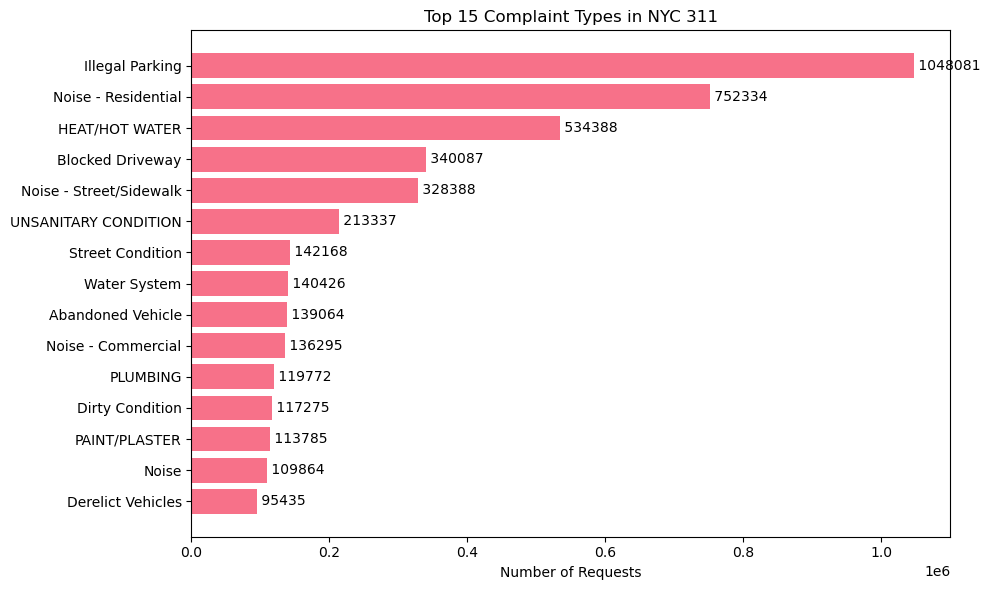

In [38]:
# Chart 1: Top Complaint Types Bar Chart
top15 = df['Complaint Type'].value_counts().head(15)

labels = top15.index[::-1]
values = top15.values[::-1]

plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.xlabel('Number of Requests')
plt.title('Top 15 Complaint Types in NYC 311')
# Add value labels
i = 0
for v in values:
    plt.text(v, i, ' ' + str(v), va='center')
    i = i + 1 

plt.tight_layout()
plt.show()

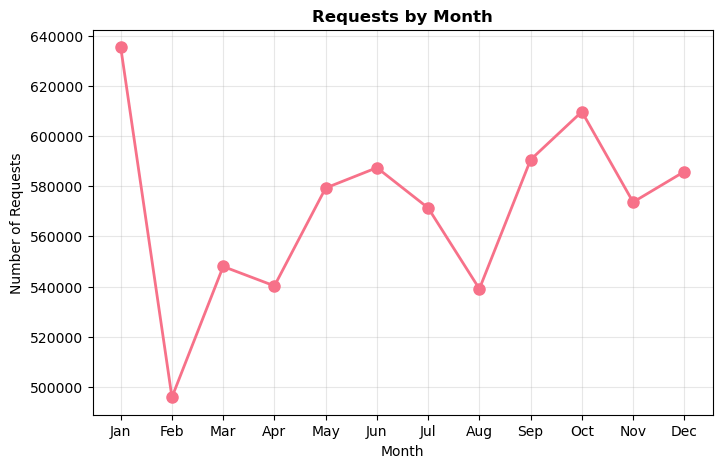

In [32]:
# Chart 2: Seasonality: Monthly Pattern
plt.figure(figsize=(8, 5))
monthly_counts = df.groupby('Month').size()
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linewidth=2, markersize=8)
plt.title('Requests by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

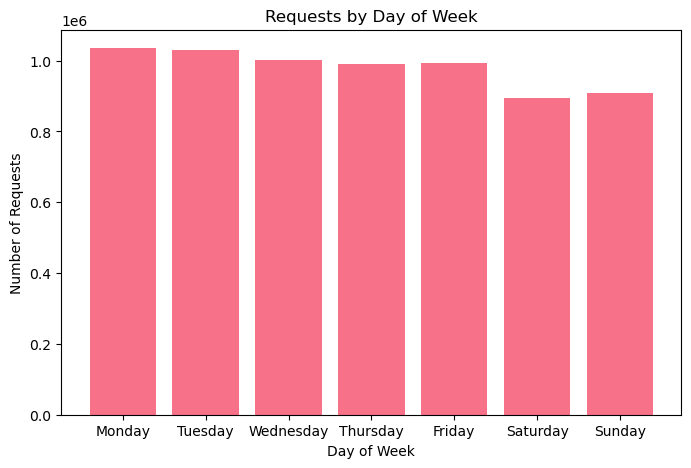

In [37]:
# Chart 3: Weekly Pattern
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df['DayOfWeek'].value_counts().reindex(dow_order)

plt.figure(figsize=(8, 5))
plt.bar(dow_order, dow_counts.values) 
plt.title('Requests by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Requests')
plt.show()

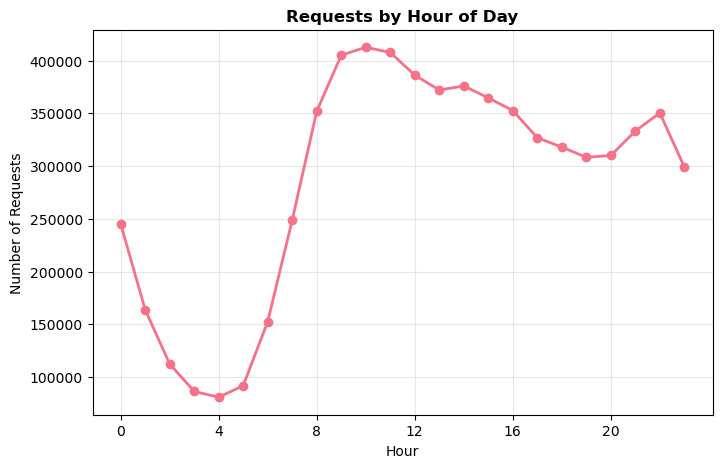

In [34]:
# Chart 4: Hourly Pattern
plt.figure(figsize=(8, 5))
hourly_counts = df['Hour'].value_counts().sort_index()
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linewidth=2, markersize=6)
plt.title('Requests by Hour of Day', fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Number of Requests')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 4))
plt.show()

In [35]:
# Key Insights:
print("KEY FINDINGS:")
total_requests = len(df)
date_span = (df['Created Date'].max() - df['Created Date'].min()).days

# Dataset overview metrics
print(f"\nDATASET OVERVIEW:")
print(f"  • Total Service Requests: {total_requests:,}")
print(f"  • Time Period: {date_span} days ({df['Created Date'].min().strftime('%Y-%m-%d')} to {df['Created Date'].max().strftime('%Y-%m-%d')})")
print(f"  • Average Daily Requests: {total_requests/date_span:.0f}")

# Service request patterns
top_complaint = df['Complaint Type'].value_counts().index[0]
top_complaint_pct = (df['Complaint Type'].value_counts().iloc[0] / len(df)) * 100
print(f"\nCOMPLAINT INSIGHTS:")
print(f"  • Most Common Complaint: {top_complaint} ({top_complaint_pct:.1f}%)")
print(f"  • Total Complaint Types: {df['Complaint Type'].nunique()}")

# Seasonal pattern analysis
busiest_month = monthly_avg.idxmax()
busiest_day = dow_counts.idxmax()
busiest_hour = hourly_counts.idxmax()
print(f"\nTEMPORAL PATTERNS:")
print(f"  • Busiest Month: {month_names[busiest_month-1]} (month #{busiest_month})")
print(f"  • Busiest Day: {busiest_day}")
print(f"  • Peak Hour: {busiest_hour}:00")

# Geographic distribution insights
busiest_borough = borough_stats.index[0]
busiest_borough_pct = (borough_stats.iloc[0] / len(df)) * 100
print(f"\n GEOGRAPHIC PATTERNS:")
print(f"  • Busiest Borough: {busiest_borough} ({busiest_borough_pct:.1f}%)")
print(f"  • Total Boroughs: {df['Borough'].nunique()}")

KEY FINDINGS:

DATASET OVERVIEW:
  • Total Service Requests: 6,856,398
  • Time Period: 729 days (2023-08-25 to 2025-08-24)
  • Average Daily Requests: 9405

COMPLAINT INSIGHTS:
  • Most Common Complaint: Illegal Parking (15.3%)
  • Total Complaint Types: 220

TEMPORAL PATTERNS:
  • Busiest Month: Jan (month #1)
  • Busiest Day: Monday
  • Peak Hour: 10:00

 GEOGRAPHIC PATTERNS:
  • Busiest Borough: BROOKLYN (30.4%)
  • Total Boroughs: 6
